In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from networkx import nx
%matplotlib inline


In [2]:
# set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [6]:
# recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N = 100                     # number of neurons

# simulation params
sim_time_ms = 1000 #* 60 * 60                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi)) / C : volt (unless refractory)
'''

G = NeuronGroup(N, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''v += w * v * cm**2 * amp**-1
                        Apre += dApre
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost
                        w = clip(w + Apre, 0, wMax)''')
           
# connect synapses
#synapses.connect(condition='i!=j', p=p)
erg = nx.erdos_renyi_graph(N, p, directed=True)#use erdos renyi random graph to determine synapse connections
num_synapses = 0
for i in range(0, erg.number_of_nodes()):
    nbs = [n for n in erg.neighbors(i)]
    synapses.connect(i=[i], j=nbs)#connect neuron i to appropriate neighbors indicated in the erdos renyi graph
    num_synapses += len(nbs)

# get connection density (for use in STDP params)
p0 = p #compute_p0(G, synapses)
# print(p0)

# stdp params
wMax = 5 / N / p0 * uamp * cm**-2   # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApost = -wMax / 5 / N              # f neg (f post)
dApre = -dApost * tauPost / tauPre  # f pos (f pre)

# assign synaptic weights
# mu_w0 = wMax / 3
# sigma_w0 = wMax / 20
# synapses.w = 'mu_w0 + (0.5 - rand()) * sigma_w0'
synapses.w = "rand() * wMax * 2 / p0 / N"

# monitors
#v_mon = StateMonitor(G, 'v', record=True)
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=range(num_synapses), dt=monitor_dt_ms * ms)
# record=True, dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(0, N):
    G[i].v = (np.random.normal(0, 1)*(vTh-vR)) #initial membrane potential for each neuron in neuron group

#
# run simulation
#
run(sim_time_ms * ms, report='text')

# plots
#plot_v(v_mon, sp_mon_exc, 0, True)
#plot_spike_trains(sp_mon_exc)


WARNING    "N" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: "_Apre := Apre * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 1. s
1.0 (100%) simulated in 1s


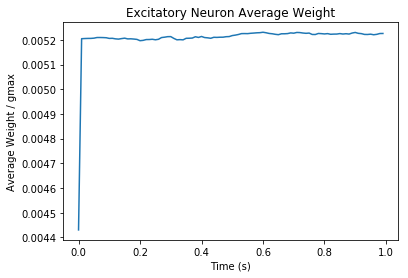

FileNotFoundError: [Errno 2] No such file or directory: 'results/motifs_N=100_t=0.99 s_1583695289.230779.png'

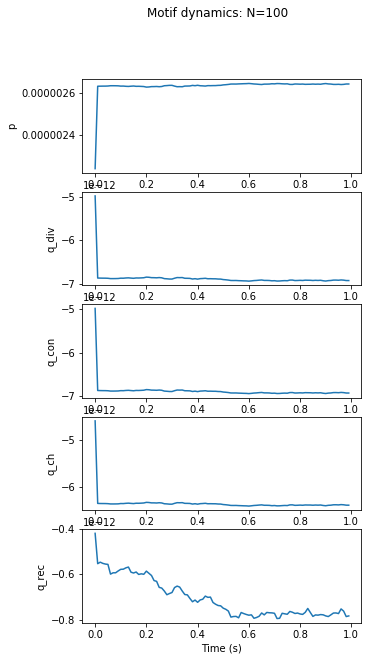

In [4]:
# more plots
plot_avg_syn_weight(w_mon, wMax)

# figure 7
plot_motif_dynamics(w_mon, synapses, N, True)

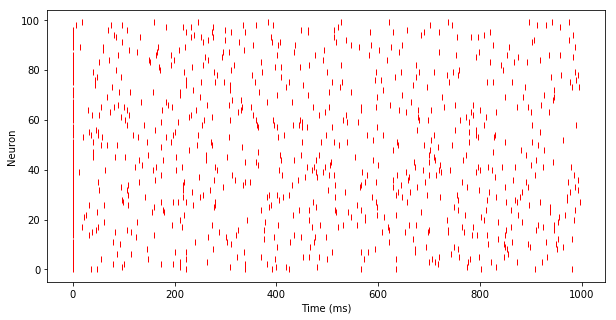

In [7]:
plot_spike_trains(sp_mon_exc)
